## **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization


from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns # for confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import json
import os
import numpy as np 

## **Load Dataset**

In [2]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## **Visualization**

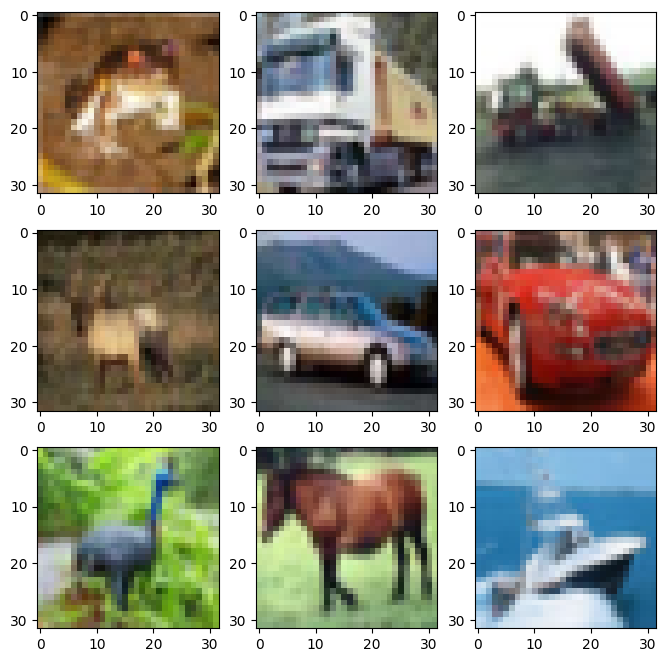

In [4]:
# create a grid of 3x3 images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = x_train[i]
    plt.imshow(img)
    
# show the plot
plt.show()

## **Preprocess and Splitting**

In [5]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
)

### Split Data

In [6]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0) # seed for fixing the x_test and y_test

In [7]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , 10) # one hot encoding
y_test = tf.keras.utils.to_categorical(y_test , 10)
y_val  = tf.keras.utils.to_categorical(y_val , 10)

datagen.fit(x_train)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(5000, 10)
(5000, 10)


## **Model**

In [9]:
weight_decay = 1e-4
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, name="outputs")
])

model.summary()

c:\Users\hashe\OneDrive - American University of Beirut\Desktop\AUB CSE\E3\TexasAM-AISchool\Project\ML-KnowledgeDistillation\Venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,201,418 (8.40 MB)

 Trainable params: 2,199,114 (8.39 MB)

 Non-trainable params: 2,304 (9.00 KB)

### Training

In [10]:
opt =    tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model.compile(
    optimizer=opt, 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [11]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [12]:
epoch = 50
history = model.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)//64, validation_data = (x_val , y_val) , verbose = 1, callbacks=callbacks)

Epoch 1/50


c:\Users\hashe\OneDrive - American University of Beirut\Desktop\AUB CSE\E3\TexasAM-AISchool\Project\ML-KnowledgeDistillation\Venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 225s 282ms/step - accuracy: 0.3445 - loss: 2.1432 - val_accuracy: 0.5438 - val_loss: 1.3694 - learning_rate: 0.0010
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 3:25 264ms/step - accuracy: 0.6406 - loss: 1.2869

C:\Users\hashe\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6406 - loss: 1.2869 - val_accuracy: 0.5472 - val_loss: 1.3496 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 223s 285ms/step - accuracy: 0.5816 - loss: 1.2665 - val_accuracy: 0.4594 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7031 - loss: 0.9788 - val_accuracy: 0.4612 - val_loss: 2.0387 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 229s 292ms/step - accuracy: 0.6680 - loss: 1.0351 - val_accuracy: 0.6718 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6094 - loss: 1.1171 - val_accuracy: 0.6740 - val_loss: 1.0808 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 226s 289ms/step - accuracy: 0.7146 - loss: 0.9323 - val_accuracy: 0.7468 - val_loss: 0.8571 - learning_rate: 0.0010
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6719 - loss: 0.8938 -

## **Results and Save**

### **Results**

In [13]:
def plot_results(model):
    epoch = max(
        [
            len(history.history[key]) for key in ["accuracy","val_accuracy","loss","val_loss"]
        ]
        )
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Classification Accuracy")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig("Model loss")
    plt.show()

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    classes (list): List of class names for labeling the axes in the plot.
    cmap (matplotlib.colors.Colormap, optional): Colormap to be used for the plot. Defaults to plt.cm.Blues.
    
    Returns:
    None: Displays the confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate model performance metrics including accuracy, precision, recall, and F1 score.
    
    Args:
    y_true (list or array): Actual true labels.
    y_pred (list or array): Predicted labels from the model.
    
    Returns:
    dict: A dictionary containing all the scores.
    """
    scores = {}
    scores['accuracy'] = accuracy_score(y_true, y_pred)
    scores['precision'] = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for unweighted mean
    scores['recall'] = recall_score(y_true, y_pred, average='macro')
    scores['f1_score'] = f1_score(y_true, y_pred, average='macro')
    
    return scores

In [15]:
acc = model.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8884 - loss: 0.5419
test set loss :  0.5422576665878296
test set accuracy : 88.98000121116638


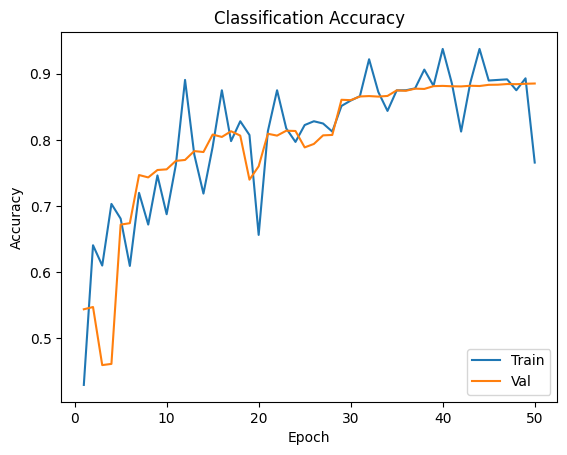

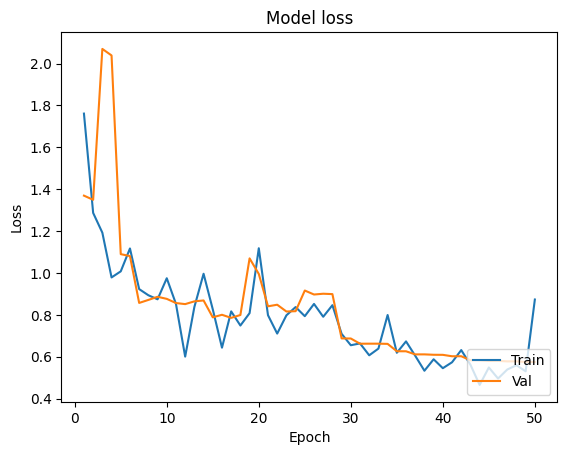

In [16]:
plot_results(model)

### Confusion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


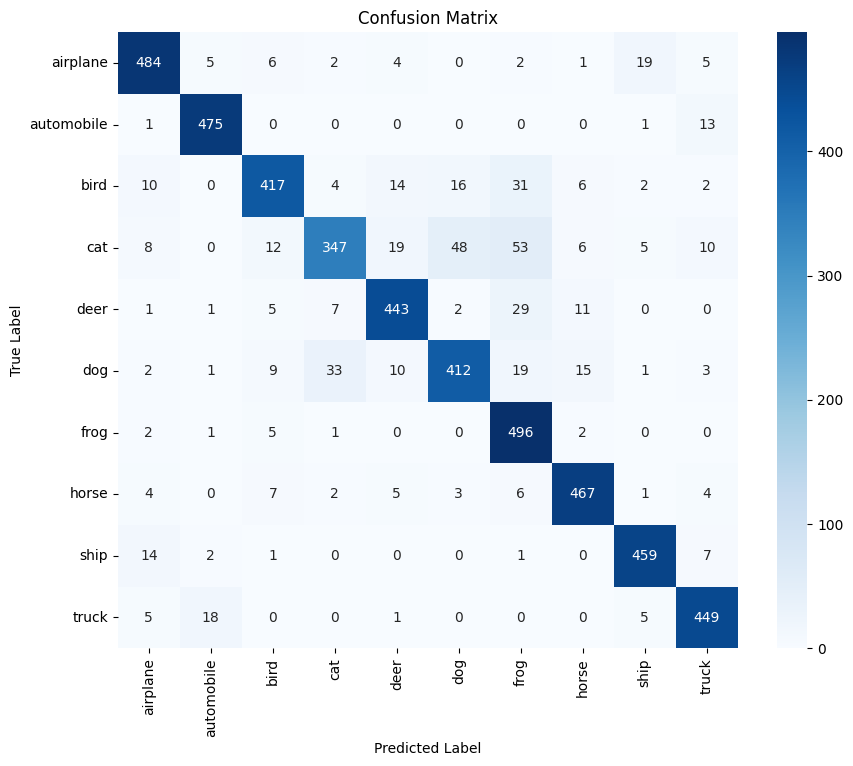

In [17]:
# Calculate the confusion matrix
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Make predictions
y_pred = model.predict(x_test)
# Convert predictions from probabilities to labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)

# Assuming y_test is also in a one-hot encoded format, convert it to labels
y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = plot_confusion_matrix(y_true_labels, y_pred_labels,class_names)


### Other Scores

In [18]:
# Evaluate other performance metrics
performance_scores = evaluate_model_performance(y_true_labels, y_pred_labels)
print("Performance Scores:")
for score_name, score_value in performance_scores.items():
    print(f"{score_name.capitalize()}: {score_value}")

Performance Scores:
Accuracy: 0.8898
Precision: 0.8924102051616206
Recall: 0.8905272856400275
F1_score: 0.8888834299791467


### Save

In [19]:
from random import randint
def saveModel(model, history: dict, dir_prefix: str = r"..\NoteBook\Teacher", dir_output:str=r"Teacher-1"):
    """
    Creates a directory and saves the model in .h5 format, training history as a JSON file,
    and training and test datasets as .npy files.

    Args:
    model (tf.keras.Model): The trained Keras model to save.
    history (dict): Dictionary containing the training history.
    x_test, y_test, x_train, y_train (numpy.ndarray): Datasets to save.
    output_dir (str, optional): The directory to save all files. Defaults to "TeacherModel".

    Returns:
    bool: True if all files are saved successfully, False if an error occurs.
    """
    try:        
    # Create the directory if it does not exist
        dir_path = os.path.join(dir_prefix, dir_output)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        history_path = os.path.join(dir_path, "history.json")
        with open(history_path, 'w') as f:
            f.write(json.dumps(history,indent=4))
            f.close()

        model_path = os.path.join(dir_path, "model.keras")
        model.save(model_path)
        

        return True
    except Exception as e:
        print(type(e))
        print(f"An error occurred: {e}")
        
        return False


In [20]:
# print(history.history)
index = 3
print(saveModel(model,history.history,dir_output=f"Teacher-{index}"))

True
